In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%%time
df = pd.read_excel('./indeed_results_pp_2020-04-27.xlsx')

Wall time: 1min 18s


In [3]:
d = df[(df['Title_New'].notnull()) & ((df['Education_Tenth'] == 1) | (df['Education_Twelvth'] == 1) | (df['Education_Bachelors'] == 1) | (df['Education_Masters'] == 1) | (df['Education_Doctorate'] == 1))].reset_index()[['Title_New', 'Education_Tenth', 'Education_Twelvth', 'Education_Bachelors', 'Education_Masters', 'Education_Doctorate']]
d['Title_New'] = d['Title_New'].astype('category')
d['Categorical_Title'] = d['Title_New'].cat.codes
d['Categorical_Title'].nunique()

16

In [4]:
cat_cols = ['Education_Tenth', 'Education_Twelvth', 'Education_Bachelors', 'Education_Masters', 'Education_Doctorate']
cont_cols = []
y_col = ['Categorical_Title']

In [5]:
cats = np.stack([d[col] for col in cat_cols], axis=1)
cats = torch.tensor(cats, dtype=torch.int64)
cats

tensor([[0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]])

In [6]:
cats.shape

torch.Size([5340, 5])

In [7]:
y = torch.tensor(d[y_col].values, dtype=torch.int64).flatten()
y.shape

torch.Size([5340])

In [8]:
cat_szs = [len(df[col]) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(90700, 50), (90700, 50), (90700, 50), (90700, 50), (90700, 50)]

In [9]:
catz = cats[:4]
catz

tensor([[0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]])

In [10]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(90700, 50)
  (1): Embedding(90700, 50)
  (2): Embedding(90700, 50)
  (3): Embedding(90700, 50)
  (4): Embedding(90700, 50)
)

In [11]:
list(enumerate(selfembeds))

[(0, Embedding(90700, 50)),
 (1, Embedding(90700, 50)),
 (2, Embedding(90700, 50)),
 (3, Embedding(90700, 50)),
 (4, Embedding(90700, 50))]

In [12]:
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.9117, -2.4320,  0.9120,  1.1426, -0.0574,  0.3116, -1.6541, -0.8689,
           1.1779,  0.4037, -1.0449, -0.3239,  0.3059, -0.7542,  0.7342, -0.2572,
           1.0755,  0.6817,  1.9141, -0.1283, -1.2220,  0.1389, -0.7962,  0.4024,
          -0.4053, -1.5648,  1.2346,  0.3743, -1.2809,  0.1208, -1.1782,  1.0704,
          -0.3191, -0.0422, -0.7438,  1.1159, -0.8702, -0.5665,  1.3211, -0.6472,
          -1.0091, -2.3856,  0.1327, -0.0152,  1.4362,  2.5653,  1.1914,  0.4501,
           2.1092, -0.4698],
         [ 0.9117, -2.4320,  0.9120,  1.1426, -0.0574,  0.3116, -1.6541, -0.8689,
           1.1779,  0.4037, -1.0449, -0.3239,  0.3059, -0.7542,  0.7342, -0.2572,
           1.0755,  0.6817,  1.9141, -0.1283, -1.2220,  0.1389, -0.7962,  0.4024,
          -0.4053, -1.5648,  1.2346,  0.3743, -1.2809,  0.1208, -1.1782,  1.0704,
          -0.3191, -0.0422, -0.7438,  1.1159, -0.8702, -0.5665,  1.3211, -0.6472,
          -1.0091, -2.3856,  0.1327, -0.0152,  1.4362,  2.5653,  1.19

In [13]:
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.9117, -2.4320,  0.9120,  1.1426, -0.0574,  0.3116, -1.6541, -0.8689,
          1.1779,  0.4037, -1.0449, -0.3239,  0.3059, -0.7542,  0.7342, -0.2572,
          1.0755,  0.6817,  1.9141, -0.1283, -1.2220,  0.1389, -0.7962,  0.4024,
         -0.4053, -1.5648,  1.2346,  0.3743, -1.2809,  0.1208, -1.1782,  1.0704,
         -0.3191, -0.0422, -0.7438,  1.1159, -0.8702, -0.5665,  1.3211, -0.6472,
         -1.0091, -2.3856,  0.1327, -0.0152,  1.4362,  2.5653,  1.1914,  0.4501,
          2.1092, -0.4698,  2.0129,  0.4562, -0.6227, -1.2657,  0.7417,  0.4831,
         -1.3611, -0.6021, -0.0191, -1.7164, -0.4735,  1.0028,  0.5740,  1.3511,
         -1.1608,  0.7749,  0.4981,  0.5811, -1.1209,  0.4122,  0.9667,  0.3292,
          0.6088, -1.6803, -1.0636,  1.9971,  1.4741,  0.9539,  1.0946,  0.4552,
          0.0856, -0.6064,  0.7899, -0.8798, -0.7902, -2.7178,  2.0392,  0.9844,
         -0.1817,  1.0628, -1.7164, -0.3907,  0.5818,  1.6086, -0.6816, -0.1642,
          1.7006,  0.0863, -

In [14]:
selfembdrop = nn.Dropout(.4)

In [15]:
z = selfembdrop(z)
z

tensor([[ 0.0000, -4.0533,  1.5200,  0.0000, -0.0000,  0.5193, -0.0000, -1.4482,
          0.0000,  0.0000, -0.0000, -0.5399,  0.5098, -1.2570,  1.2236, -0.4287,
          1.7924,  0.0000,  3.1902, -0.2139, -2.0366,  0.0000, -0.0000,  0.6706,
         -0.6754, -2.6080,  2.0576,  0.6239, -0.0000,  0.2013, -0.0000,  1.7841,
         -0.5318, -0.0000, -1.2397,  1.8599, -0.0000, -0.9442,  0.0000, -1.0786,
         -1.6819, -3.9760,  0.0000, -0.0253,  0.0000,  0.0000,  1.9857,  0.7502,
          0.0000, -0.7830,  3.3548,  0.7604, -0.0000, -0.0000,  0.0000,  0.8052,
         -2.2686, -0.0000, -0.0319, -2.8607, -0.0000,  1.6714,  0.0000,  0.0000,
         -1.9346,  1.2915,  0.0000,  0.0000, -1.8682,  0.6871,  0.0000,  0.5487,
          1.0147, -0.0000, -1.7727,  3.3285,  2.4568,  1.5898,  1.8243,  0.7587,
          0.0000, -0.0000,  0.0000, -1.4664, -0.0000, -0.0000,  3.3987,  1.6406,
         -0.3028,  0.0000, -2.8606, -0.0000,  0.9696,  0.0000, -0.0000, -0.2736,
          0.0000,  0.0000, -

In [16]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x = torch.cat([x], 1)
        x = self.layers(x)
        return x

In [17]:
torch.manual_seed(33)
model = TabularModel(emb_szs, 16, [200, 100, 50, 25, 50, 100, 200], p=0.4)

In [18]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(90700, 50)
    (1): Embedding(90700, 50)
    (2): Embedding(90700, 50)
    (3): Embedding(90700, 50)
    (4): Embedding(90700, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=250, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=25, bias=True)
    (13): ReLU(inplace

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
%%time
epochs = 5000
losses = []

for i in range(epochs):
    y_pred = model(cats)
    loss = criterion(y_pred, y)
    losses.append(loss)
    
    if (i+1)%500 == 0:
        print(f'epoch: {(i+1):5}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:   500  loss: 2.19426656
epoch:  1000  loss: 2.16728044
epoch:  1500  loss: 2.16184449
epoch:  2000  loss: 2.15958977
epoch:  2500  loss: 2.15022063
epoch:  3000  loss: 2.15031338
epoch:  3500  loss: 2.14382553
epoch:  4000  loss: 2.14549565
epoch:  4500  loss: 2.14109015
epoch:  5000  loss: 2.14247727
Wall time: 1h 6min 1s


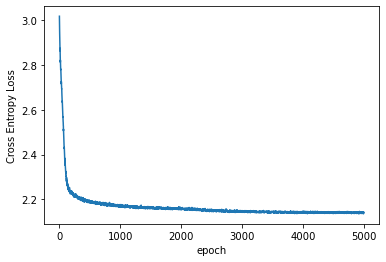

In [21]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [22]:
with torch.no_grad():
    y_val = model(cats)
    loss = criterion(y_val, y)
print(f'CE Loss: {loss:.8f}')

CE Loss: 2.14161873


In [25]:
rows = d.shape[0]
correct = 0
print(f'ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{y_val[i].argmax():^7}{y[i]:^7}')
    if y_val[i].argmax().item() == y[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

ARGMAX  Y_TEST
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      5   
  10      7   
  10      7   
  10     12   
  10      7   
  10      7   
  10      7   
  10      7   
  10     11   
  10     11   
  10     11   
  10     14   
  10      7   
  10      0   
  10      3   
  10      3   
  10      3   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
   6      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      5   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      5   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      7   
  10      

  10     10   
  10     10   
   6      9   
  10      3   
   9      3   
  10      6   
  10      6   
  10      6   
  10      2   
  10      8   
  10      2   
  10      3   
  10      8   
  10      8   
  10      8   
  10      2   
  10      3   
  10     15   
  10     15   
  10     11   
  10      6   
  10      5   
  10     13   
  10      0   
  10     15   
  10      7   
  10      7   
  10      9   
  10      9   
   9     10   
  10     10   
  10     10   
   9     10   
  10     10   
  10     10   
   9     10   
  10     10   
  10     10   
   6     10   
  10     10   
  10     10   
  10      6   
  10     10   
  10      0   
  10     10   
  10     11   
  10      9   
  10     10   
  10      7   
  10     11   
  10      7   
  10      9   
  10      9   
  10      1   
   9     10   
  10      1   
  10      3   
   9     10   
  10      9   
  10      9   
  10      6   
  10      6   
  10     13   
  10     10   
  10     10   
  10     10   
  10     1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




  10     15   
  10      6   
  10      0   
  10     10   
  10      9   
  10      2   
  10      9   
  10      9   
  10      6   
  10     10   
  10     15   
  10     15   
  10     15   
  10     15   
  10      5   
  10     15   
  10     15   
  10      0   
  10     12   
  10     10   
  10      5   
  10     10   
  10     10   
  10     10   
  10     10   
  10     10   
  10     10   
  10      6   
   3      3   
  10     10   
  10      8   
  10      3   
  10      6   
  10      3   
  10     10   
  10      3   
  10      3   
  10     10   
  10     10   
  10     10   
  10     10   
  10      0   
  10     11   
  10     11   
  10      9   
  10      9   
  10      9   
  10      9   
  10      9   
  10      9   
  10      5   
  10      0   
   9      6   
  10     15   
  10      0   
  10      0   
  10     10   
  10     10   
  10     10   
  10      6   
  10     10   
   6      6   
  10      6   
  10      6   
  10      0   
  10      9   
  10     

  10      2   
  10     10   
  10      9   
  10      9   
  10     12   
  10     15   
  10     15   
  10     12   
  10      6   
  10      3   
  10     10   
  10     11   
  10     10   
  10      3   
   5      5   
   3      3   
  10      2   
  10     13   
  10     15   
  10      3   
  10      9   
  10     10   
  10      5   
  10      5   
  10      6   
  10      2   
  10      7   
  10      7   
  10     13   
  10      6   
  10      0   
  10      0   
  10     15   
  10      6   
  10      7   
  10      6   
  10     15   
  10      6   
  10      0   
  10      6   
  10      3   
  10     10   
  10      9   
  10      7   
  10      7   
  10      7   
  10     12   
  10      5   
  10      9   
  10      9   
  10      9   
  10      9   
  10      9   
  10     10   
  10      6   
   6      6   
  10     11   
  10      5   
  10      5   
  10      5   
  10     10   
  10     10   
  10      9   
  10     11   
  10     11   
  10     10   
  10     1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




  10     10   
  10      9   
  10      6   
  10     10   
  10     10   
  10      9   
  10     10   
  10      9   
  10     10   
  10     10   
  10      3   
  10      9   
  10     10   
  10     10   
  10      6   
  10      6   
  10      6   
  10      6   
  10      2   
  10      5   
  10     15   
  10     11   
  10      6   
  10      8   
  10     10   
  10     10   
  10     10   
  10      3   
  10      6   
  10     10   
  10      3   
  10      3   
  10      2   
  10     10   
  10     10   
  10      9   
  10     13   
  10      7   
  10      0   
  10      0   
  10     12   
  10      5   
  10      5   
  10     15   
  10     10   
  10     10   
  10      0   
  10     15   
  10      6   
  10      6   
  10      5   
  10      5   
  10     10   
  10      9   
  10      5   
  10      6   
  10      1   
  10      6   
  10      0   
  10      5   
  10      0   
  10      6   
  10      9   
  10     10   
   6      0   
  10      6   
  10     